# Data Extraction

In [1]:
import numpy as np
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt

### VEHICLE DATA

In [2]:
ipa = pd.read_csv('Data/carapi-opendatafeed-sample.csv')
ipa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17662 entries, 0 to 17661
Data columns (total 57 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Make Id                                      17662 non-null  int64  
 1   Make Name                                    17662 non-null  object 
 2   Model Id                                     17662 non-null  int64  
 3   Model Name                                   17662 non-null  object 
 4   Trim Id                                      17662 non-null  int64  
 5   Trim Year                                    17662 non-null  int64  
 6   Trim Name                                    17662 non-null  object 
 7   Trim Description                             17662 non-null  object 
 8   Trim Msrp                                    17662 non-null  int64  
 9   Trim Invoice                                 17662 non-null  int64  
 10

In [3]:
print(f"Unique ['Make Id'] inputs: {ipa['Make Id'].nunique()}\n")
print(f"Body types: {ipa['Body Type'].unique()}\n")
print(f"Engine types: {ipa['Engine Type'].unique()}")

Unique ['Make Id'] inputs: 45

Body types: ['Sedan' 'SUV' 'Coupe' 'Convertible' 'Wagon' 'Hatchback'
 'Truck (Extended Cab)' 'Truck (Crew Cab)' 'Van' 'Ext Van'
 'Truck (Double Cab)' 'Truck (Regular Cab)' 'Minivan' 'Truck (SuperCrew)'
 'Truck (SuperCab)' 'Truck (King Cab)' 'Truck (Quad Cab)'
 'Truck (Mega Cab)' 'Truck (Access Cab)' 'Truck (CrewMax)' 'Cargo Van'
 'Passenger Van']

Engine types: ['gas' 'hybrid' 'mild hybrid' 'plug-in hybrid' 'electric'
 'flex-fuel (FFV)' 'diesel' 'electric (fuel cell)' 'natural gas (CNG)']


We have imported the Cars dataset from IPA. We currently have 17662 rows and 57 columns. Because of the small amount of distincitve ['Make Id'], we will divide the 'ipa' into 4 main engine types: electric, hybrid, gas and diesel, to avoid losses due to duplicate drops. We will drop duplicates based on the 

There are only 45 unique ['Make Id'], hence we will first divide the ipa into 4 main engine types: electric, hybrid, gas and diesel, such that we avoid losses due to duplicate drops.

In [4]:
# Classify as ... if ...
    # Electric <=> ['Engine Type'] is 'electric'
ev = ipa[ipa['Engine Type']== 'electric']
    # Hybrid <=> ['Engine Type'] contains 'hybrid'
hyb = ipa[ipa['Engine Type'].str.contains('hybrid')]
    # Gas <=> ['Engine Type'] is 'gas'
gas = ipa[ipa['Engine Type'] == 'gas']
    # diesel <=> ['Engine Type'] is 'diesel'
dis = ipa[ipa['Engine Type'] == 'diesel']

The newly distinguished dataframes have the same columns: ['Make Name', 'Model Name', 'Body Type', 'Engine Type', 'Body Wheel Base', 'Body Curb Weight', 'Engine Drive Type']. Additionally, the conventional vehicles (gas and diesel) have the additional categories: 'Mileage Fuel Tank Capacity' and 'Mileage Combined Mpg'. Electric vehicles have

In [5]:
common = ['Make Name', 'Model Name', 'Body Type', 'Engine Type', 'Body Wheel Base',
         'Body Curb Weight', 'Engine Drive Type']

ev  =  ev[common + ['Mileage Battery Capacity Electric']].dropna()
gas = gas[common + ['Mileage Fuel Tank Capacity', 'Mileage Combined Mpg']].dropna()
dis = dis[common + ['Mileage Fuel Tank Capacity', 'Mileage Combined Mpg']].dropna()
hyb = hyb[common + ['Mileage Fuel Tank Capacity', 'Mileage Combined Mpg', 'Mileage Range Electric']].dropna()

Conversion to SI Units:

In [6]:
def m2km(mil):
    """ Converts miles to kilometers
        1 mi = 1.609344 km"""
    return 1.609344*mil

def lbs2kg(lbs):
    """ Converts pounds to kilogram
        1 lbs = 0.45359237 kg """
    # 1 HP is equal to 0.746 kWh
    return 0.45359237*lbs

def inch2m(inch): 
    """ Converts inches to meter
        1 inch = 0.0254 m """
    return 0.0254*inch

def mph2ms(mph):
    """ Converts miles per hour to
            meter per second
        1 mph = 0.44704 m/s """
    return 0.44704*mph

def gal2l(gal):
    """ Converts gallons to liters
        1 gal = 3.78541 l """
    return 3.78541*gal

def cog(BT):
    """ Returns the assumed height
            of the center of gravity 
            for the given body type
        Data: ChatGPT
    """
    cog_map = {'SUV': 0.52,
               'Sedan': 0.55,
               'Wagon': 0.56,
               'Hatchback': 0.54,
               'Coupe': 0.52,
               'Convertible': 0.53,
    }
    
    if BT in cog_map:
        return cog_map[BT]
    elif 'Van' in BT:
        return 0.66
    elif 'Truck' in BT:
        return 0.7

def cap(ET, BT):
    """ Returns the assumed Batter 
            Capacity [kWh] based on
            Body Type for hybrid cars
        Data: ChatGPT
    """
    cap_map = {
        'hybrid': {
            'SUV': 1.5,
            'Sedan': 1.3,
            'Wagon': 1.3,
            'Hatchback': 1.2, 
            'Coupe': 1.,
            'Convertible': 1.,
            'Van': 1.5,
            'Truck': 1.8
        },
        'mild hybrid': {
            'SUV': 0.6,
            'Sedan': 0.5,
            'Wagon': 0.5,
            'Hatchback': 0.5, 
            'Coupe': 0.4,
            'Convertible': 0.4,
            'Van': 0.6,
            'Truck': 0.7
        },
        'plug-in hybrid': {
            'SUV': 14,
            'Sedan': 12,
            'Wagon': 12,
            'Hatchback': 11, 
            'Coupe': 10,
            'Convertible': 10,
            'Van': 13,
            'Truck': 15
        }
    }
    
    try:
        return cap_map[ET][BT]
    except KeyError:
        return 0
    
def drag_coef(BT):
    """ Returns the assumed drag
            coefficient for given 
            body type
        Data: ChatGPT
    """
    cog_map = {'SUV': 0.35,
               'Sedan': 0.27,
               'Wagon': 0.29,
               'Hatchback': 0.3,
               'Coupe': 0.26,
               'Convertible': 0.31,
    }
    
    if BT in cog_map:
        return cog_map[BT]
    elif 'Van' in BT:
        return 0.38
    elif 'Truck' in BT:
        return 0.42
    
def front_area(BT):
    """ Returns the assumed drag
            coefficient for given 
            body type
        Data: ChatGPT
    """
    cog_map = {'SUV': 2.6,
               'Sedan': 2.2,
               'Wagon': 2.2,
               'Hatchback': 2.1,
               'Coupe': 2.,
               'Convertible': 2.1,
    }
    
    if BT in cog_map:
        return cog_map[BT]
    elif 'Van' in BT:
        return 2.7
    elif 'Truck' in BT:
        return 2.8
    
def E_f(T, type):
    """ Calculates the Fuel Energy
        based on the Engine Type and
        Tank Capacity T
        (Input)
            [T]: liter
            type: gas, diesel or hybrid
        (Output)
            [E_F]: kWh
    """
    if type == 'diesel':
        # Energy Density = 33.526 MJ/L
        return np.around(33.526/3.6*T)
    else: # Gas or Hybrid
        # Energy Density = 34.2 MJ/l
        return np.around(34.2/3.6*T)


def name(make, model):
    return make + " " + model

Applying the above function to convert units and establish the 'Height of Center of Gravity' and the the name of the vehicle (saved as 'Vehicle'). Bassed on the vehicle's name duplicates will be filtered out.

In [7]:
# Total Range of conventional cars with unit conversion
for conv in [gas, dis, hyb]:
    conv['Fuel Tank Capacity'] = np.vectorize(gal2l)(conv['Mileage Fuel Tank Capacity'])
    conv['Fuel Energy'] = np.vectorize(E_f)(conv['Fuel Tank Capacity'], conv['Engine Type'])


# Add assumed Batter Capacity [kWh] based on Body Type for hybrid cars
hyb['Mileage Battery Capacity Electric'] = np.vectorize(cap)(hyb['Engine Type'], hyb['Body Type'])

for df in [ev, gas, dis, hyb]:
    # Lbs -> kg
    df['Body Curb Weight'] = np.vectorize(lbs2kg)(df['Body Curb Weight'])
    # Inch -> m
    df['Body Wheel Base'] = np.vectorize(inch2m)(df['Body Wheel Base'])
    # Center of Gravity
    df['Height of Center of Gravity'] = np.vectorize(cog)(df['Body Type'])
    # Drag Coefficient
    df['Drag Coefficient'] = np.vectorize(drag_coef)(df['Body Type'])
    # Frontal Area
    df['Frontal Area'] = np.vectorize(front_area)(df['Body Type'])
    # Name of Vehicle
    df['Vehicle'] = np.vectorize(name)(df['Make Name'], df['Model Name'])

Drop duplicates based on vehicle's name ('Vehicle') and dispansable columns.

In [8]:
# Drop duplicates
ev = ev.drop_duplicates(['Vehicle']).reset_index(drop=True)
gas = gas.drop_duplicates(['Vehicle']).reset_index(drop=True) 
dis = dis.drop_duplicates(['Vehicle']).reset_index(drop=True)
hyb = hyb.drop_duplicates(['Vehicle']).reset_index(drop=True)

# Asserting dispensable columns by Engine Type
## Common columns
disp = ['Make Name', 'Model Name']
## Electric Vehicle Columns
## Convenctional Vehicle Columns
disp_c = ['Mileage Combined Mpg', 'Mileage Fuel Tank Capacity', 'Fuel Tank Capacity']

# Dropping dispensable columns
gas = gas.drop(disp + disp_c, axis=1)
dis = dis.drop(disp + disp_c, axis=1)
ev = ev.drop(disp, axis=1)
hyb = hyb.drop(disp + disp_c + ['Mileage Range Electric'], axis=1)

We will rename the columns to align it with the needs of the theoretical model:

\begin{equation*}
    \begin{array}{c | c | c}
            \hline
            \hline
        \text{Old Name} & \text{New Name} & \text{Symbol} \\ 
            \hline 
            \hline
        \text{'Body Curb Weight'} & \text{'M'} & M \\ 
            \hline
        \text{'Body Wheel Base'} & \text{'2a'} & 2a \\
        \text{'Drag Coefficient'} & \text{'c\_D'} & c_D \\
        \text{'Frontal Area'} & \text{'A\_F'} & A_F \\
        \text{'Height of Center of Gravity'} & \text{'CoG'} & CoG \\
            \hline
        \text{'Body Type'} & \text{'Body'} & - \\
        \text{'Engine Type'} & \text{'Engine'} & - \\
        \text{'Engine Drive Type'} & \text{'Drive'} & - \\
            \hline
        \text{'Fuel Energy'} & \text{'E\_F}' & E_f\\
        \text{'Mileage Battery Capacity Electric'} & \text{'E\_b'} & E_b \\
        \hline
        \hline
    \end{array}
\end{equation*}

In [9]:
def rename_vehicle_columns(df):
    """ Assigns the new vehicle columns name"""
    rename_map = {'Body Curb Weight': 'M',
                  'Body Wheel Base': '2a',
                  'Drag Coefficient': 'c_D',
                  'Frontal Area': 'A_F',
                  'Height of Center of Gravity': 'CoG',
                  'Body Type': 'Body',
                  'Engine Type': 'Engine',
                  'Engine Drive Type': 'Drive',
                  'Fuel Energy': 'E_f',
                  'Mileage Battery Capacity Electric': 'E_b',
                  }

    return df.rename(columns=rename_map)

In [10]:
# Renames vehicles columsn
ev = rename_vehicle_columns(ev).dropna()
hyb = rename_vehicle_columns(hyb).dropna()
gas = rename_vehicle_columns(gas).dropna()
dis = rename_vehicle_columns(dis).dropna()

In [11]:
# Reorganizes the columns for improved readability.
col = ['Vehicle', 'Engine', 'Body', 'Drive', 'M', '2a', 'CoG', 'c_D', 'A_F']
col_conv = ['E_f']
col_elec = ['E_b']
gas = gas[col+col_conv]
dis = dis[col+col_conv]
ev = ev[col + col_elec]
hyb = hyb[col + col_conv + col_elec]

In [12]:
# Amount of vehicles grouped by engine category
print(f'Amount of EVs: {len(ev)},\nAmount of gas vehicles: {len(gas)},\nAmount of diesel vehicles: {len(dis)}\nAmount of hybrid vehicles: {len(hyb)}.')

Amount of EVs: 23,
Amount of gas vehicles: 406,
Amount of diesel vehicles: 34
Amount of hybrid vehicles: 37.


In [13]:
ev.to_csv('Data/ev.csv', index=False)
hyb.to_csv('Data/hyb.csv', index=False)
gas.to_csv('Data/gas.csv', index=False)
dis.to_csv('Data/dis.csv', index=False)

### DRICE CYCLES

In [14]:
us06 = pd.read_csv('Data/US06Drive.csv')
wltc = pd.read_csv('Data/WLTC1.csv')
print(f'Columns of US06 Drive Cycle: {us06.columns}\nColumns of WLTC: {wltc.columns}')

Columns of US06 Drive Cycle: Index(['time', 'Speed'], dtype='object')
Columns of WLTC: Index(['Phase', 'Total elapsed time', 'Phase elapsed time',
       'WLTC class 1, version 1.4, vehicle speed',
       'WLTC class 1, version 1.4, acceleration',
       'WLTC class 1, version 1.4, acceleration.1'],
      dtype='object')


In [15]:
print(f'US06 inputs:\n{pd.concat([us06.head(3), us06.tail(3)])}\n\nWLTC inputs:')
pd.concat([wltc.head(3), wltc.tail(3)])

US06 inputs:
        time  Speed
0    Seconds  (mph)
1          0    0.0
2          1    0.0
591      590   12.9
592      591    6.2
593      592    2.2

WLTC inputs:


,Phase,Total elapsed time,Phase elapsed time,"WLTC class 1, version 1.4, vehicle speed","WLTC class 1, version 1.4, acceleration","WLTC class 1, version 1.4, acceleration.1"
0,NaN,s,s,km/h,m/s²,km/h/s
1,Low,0,0,0.0,0.00,0.00
2,Low,1,1,0.0,0.00,0.00
1021,Middle,1020,431,0.0,0.00,0.00
1022,Middle,1021,432,0.0,0.00,0.00
1023,Middle,1022,433,0.0,0.00,0.00


Both DataFrames contain their respective units in the first row. We will conduct the following steps:
1. Remove the first rows
2. Convert the dtype object to float
3. Choose necessary columns and rename the columns to 'Time' and 'Velocity'
4. Convert the unit to SI units, where velocity is shown in $\text{m}/\text{s}$, acceleration - $\text{m}/\text{s}^2$ and distance - $\text{m}$
5. Add an aditional row to the US06 Drive Cycle, where the velocity and acceleration are 0!
6. Integrate the velocity in respect to time to obtain the distance.

    \begin{align*}
        \frac{ds}{dt} & = v \\
        ds & = vdt \\
        \int ds & = \int vdt \\
        s & = \int v dt
    \end{align*}

7. Round up the number to the 2nd digit
8. Plot the Drive Cycles!


In [16]:
# Step 1., 2. and 3.
us06 = us06.drop(index=0, axis=1).astype(float).rename(columns={'Speed': 'Velocity', 'time': 'Time'})
wltc = wltc[['Total elapsed time', 'WLTC class 1, version 1.4, vehicle speed',
             'WLTC class 1, version 1.4, acceleration']].rename(columns = {'Total elapsed time': 'Time', 
                                                                     'WLTC class 1, version 1.4, vehicle speed': 'Velocity',
                                                                     'WLTC class 1, version 1.4, acceleration': 'Acceleration'})
wltc = wltc.drop(index=0).astype(float)

# Step 4.
us06['Velocity'] = np.vectorize(mph2ms)(us06['Velocity']) #m/s
us06['Acceleration'] = us06['Velocity'].diff().fillna(0) #m/s^2
wltc['Velocity'] = np.vectorize(mph2ms)(wltc['Velocity']) #m/s

# Step 5.
us06.iloc[-1] = [us06['Time'].iloc[-1], 0, 0]
us06 = us06.reset_index(drop=True)

# Step 6. 
us06['Distance'] = scp.integrate.cumulative_trapezoid(us06['Velocity'], us06['Time'], initial=0)
wltc['Distance'] = scp.integrate.cumulative_trapezoid(wltc['Velocity'], wltc['Time'], initial=0)

# Step 7
us06 = np.around(us06, 2)
wltc = np.around(wltc, 2)

In [17]:
def plot_avs(df, name):
    """ Creates the plot for the Acceleration, Velocity
        and Distance profile of the given by DataFrame [df]
        'Distance': [m]
        'Velocity': [m/s]
        'Acceleratiom': [m/s^2]"""

    # Defines figures (subfigures) and configuration
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, hspace=0)

    # Defines axes
    ax1, ax2 = gs.subplots(sharex=True)
    ax12 = ax1.twinx()
    ax22 = ax2.twinx()
    # Loops through the x-axes to set each label, grid and limit
    for ax in fig.axes:
        ax.set_xlabel("Time [s]")
        ax.grid()
        ax.set_xlim(df['Time'].iloc[0], df['Time'].iloc[-1])
    # Setting each label for the y axes
    ax1.set_ylabel('Acceleration [m/s2]', color='mediumorchid')
    ax2.set_ylabel('Velocity [km/h]', color='crimson')
    ax12.set_ylabel('Velocity [km/h]', color='crimson')
    ax22.set_ylabel('Distance [km]', color='indigo')

    # Plots the Acceleration, Velocity and Distance
    ax1.plot(df['Time'], df['Acceleration'], color='mediumorchid')
    ax12.plot(df['Time'], df['Velocity']*3.6, c='crimson')
    ax2.plot(df['Time'], df['Velocity']*3.6, c='crimson')
    ax22.plot(df['Time'], df['Distance']/1e3, c='indigo')

    ax1.set_title(name + ' Drive Cycle', loc='center', size=20)
    fig.set_tight_layout(True)
    plt.savefig('Paper/images/' + name.lower(), dpi=100)

    plt.show()

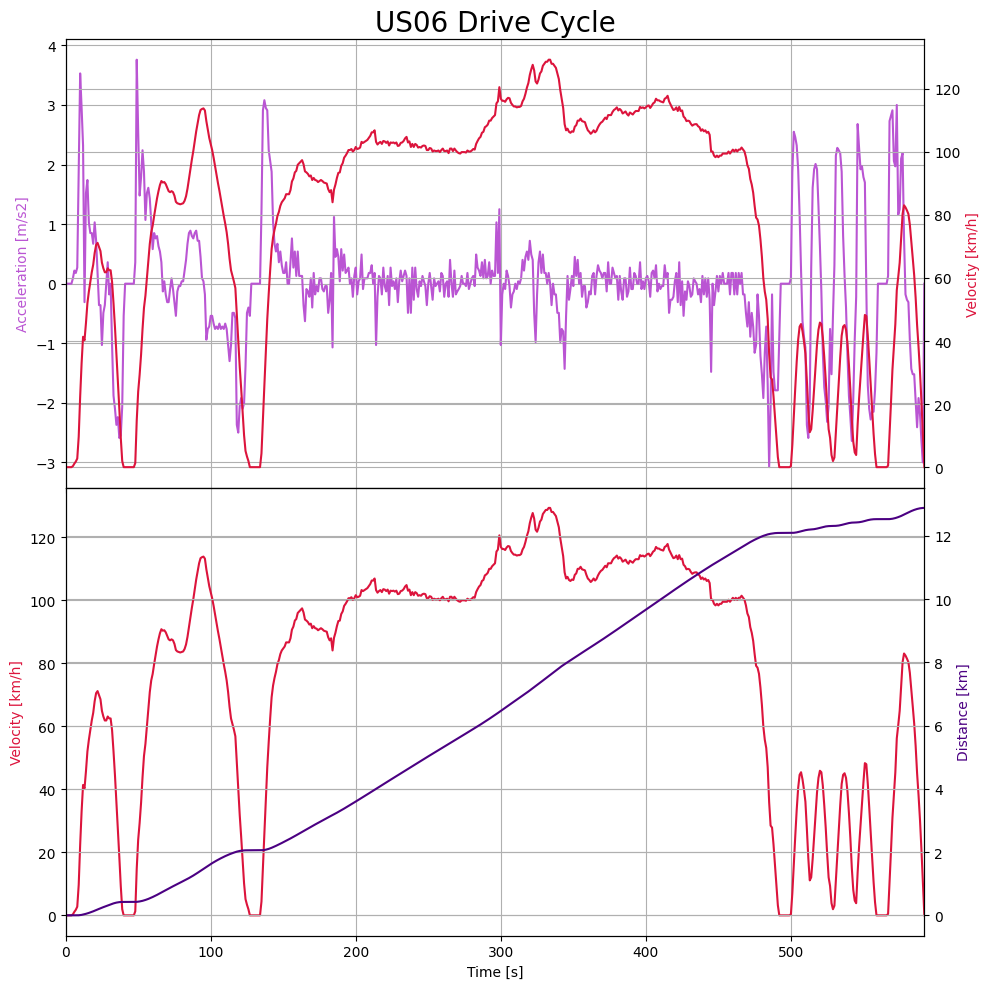

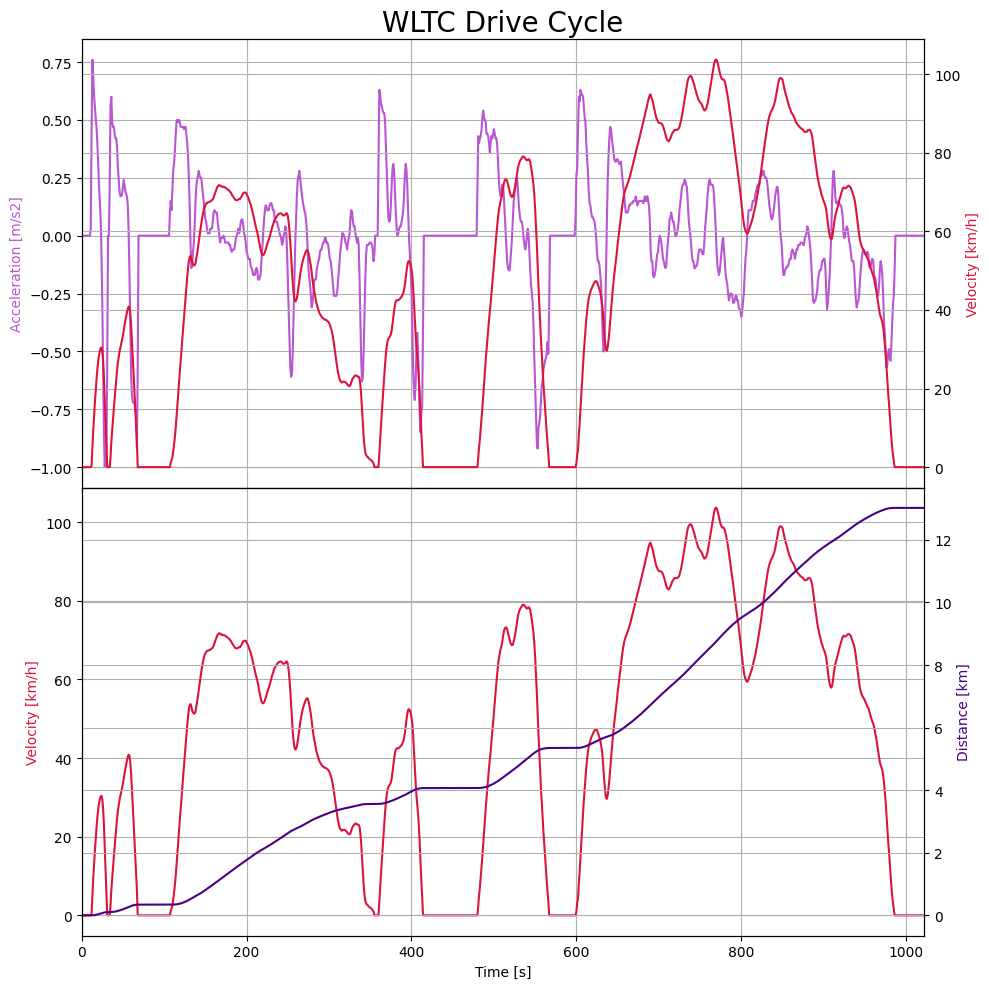

In [18]:
plot_avs(us06, 'US06')
plot_avs(wltc, 'WLTC')

In [19]:
us06.to_csv('Data/us06.csv', index=False)
wltc.to_csv('Data/wltc.csv', index=False)

In [20]:
# Maximum values of each Drive Cycle
print(f'WLTC:\n{wltc.max()}\n\nUS06:\n{us06.max()}')

WLTC:
Time             1022.00
Velocity           28.79
Acceleration        0.76
Distance        13021.07
dtype: float64

US06:
Time              592.00
Velocity           35.90
Acceleration        3.76
Distance        12886.60
dtype: float64


In [23]:
# Average Velocity of each Drive Cycle in km/h
print(f"WLTC:\n{np.around(wltc['Velocity'].mean()*3.6, 2)}\n\n"
      f"US06:\n{np.around(us06['Velocity'].mean()*3.6, 2)}")

WLTC:
45.82

US06:
78.23
